# Loading neurons from s3

In [1]:
import napari
from napari.utils import nbscreenshot
%gui qt

In [ ]:
import numpy as np
from pathlib import Path
import re
import pandas as pd
import networkx as nx
# from cloudvolume import CloudVolume, Skeleton
# from io import StringIO
# import os
from brainlit.utils.util import (
    check_type,
    check_size,
)
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
# from brainlit.utils.session import NeuroglancerSession
# from brainlit.utils.Neuron_trace import NeuronTrace
# import numpy as np
# from skimage import io
# from pathlib import Path

/Users/thomasathey/Documents/mimlab/mouselight/env/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


## Loading entire neuron from AWS 


`s3_trace = NeuronTrace(s3_path,seg_id,mip)` to create a NeuronTrace object with s3 file path
`swc_trace = NeuronTrace(swc_path)` to create a NeuronTrace object with swc file path
1. `s3_trace.get_df()` to output the s3 NeuronTrace object as a pd.DataFrame
2. `swc_trace.get_df()` to output the swc NeuronTrace object as a pd.DataFrame
3. `swc_trace.generate_df_subset(list_of_voxels)` creates a smaller subset of the original dataframe with coordinates in img space
4. `swc_trace.get_df_voxel()` to output a DataFrame that converts the coordinates from spatial to voxel coordinates
5. `swc_trace.get_graph()` to output the s3 NeuronTrace object as a netwrokx.DiGraph
6. `swc_trace.get_paths()` to output the s3 NeuronTrace object as a list of paths
7. `ViewerModel.add_shapes` to add the paths as a shape layer into the napari viewer
8. `swc_trace.get_sub_neuron(bounding_box)` to output NeuronTrace object as a graph cropped by a bounding box
9. `swc_trace.get_sub_neuron(bounding_box)` to output NeuronTrace object as paths cropped by a bounding box

### 1. `s3_trace.get_df()`
This function outputs the s3 NeuronTrace object as a pd.DataFrame. Each row is a vertex in the swc file with the following information: 

`sample number`

`structure identifier`

`x coordinate`

`y coordinate`

`z coordinate`

`radius of dendrite`

`sample number of parent`

The coordinates are given in spatial units of micrometers ([swc specification](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html))

In [3]:
# s3_path = "s3://open-neurodata/brainlit/brain1_segments"
# seg_id = 2
# mip = 1

# s3_trace = NeuronTrace(s3_path, seg_id, mip)
# df = s3_trace.get_df()
# df.head()

Downloading: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


,sample,structure,x,y,z,r,parent
0,1,0,4717.0,4464.0,3855.0,1.0,-1
1,4,192,4725.0,4439.0,3848.0,1.0,1
2,7,64,4727.0,4440.0,3849.0,1.0,4
3,8,0,4732.0,4442.0,3850.0,1.0,7
4,14,0,4749.0,4439.0,3856.0,1.0,8


### 2. `swc_trace.get_df()`
This function outputs the swc NeuronTrace object as a pd.DataFrame. Each row is a vertex in the swc file with the following information: 

`sample number`

`structure identifier`

`x coordinate`

`y coordinate`

`z coordinate`

`radius of dendrite`

`sample number of parent`

The coordinates are given in spatial units of micrometers ([swc specification](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html))

In [4]:
# swc_path = str(Path().resolve().parents[2] / "data" / "data_octree" / "consensus-swcs" / '2018-08-01_G-002_consensus.swc')

# swc_trace = NeuronTrace(path=swc_path)
# df = swc_trace.get_df()
# df.head()

,sample,structure,x,y,z,r,parent
0,1,0,-387.114438,1928.663327,-1846.508302,1.0,-1
1,2,0,-385.023123,1917.704355,-1833.659048,1.0,1
2,3,0,-385.023123,1892.742251,-1846.508302,1.0,2
3,4,0,-381.438012,1881.174447,-1858.369151,1.0,3
4,5,0,-388.010715,1881.783279,-1873.195213,1.0,4


### 3. `swc_trace.generate_df_subset(list_of_voxels)`
This function creates a smaller subset of the original dataframe with coordinates in img space. Each row is a vertex in the swc file with the following information: 

`sample number`

`structure identifier`

`x coordinate`

`y coordinate`

`z coordinate`

`radius of dendrite`

`sample number of parent`

The coordinates are given in same spatial units as the image file when using `ngl.pull_vertex_list`

In [5]:
# # Choose vertices to use for the subneuron
# subneuron_df = df[0:3] 
# vertex_list = subneuron_df['sample'].array 

# # Define a neuroglancer session
# url = "s3://open-neurodata/brainlit/brain1"
# mip = 1
# ngl = NeuroglancerSession(url, mip=mip)

# # Get vertices
# seg_id = 2
# buffer = 10
# img, bounds, vox_in_img_list = ngl.pull_vertex_list(seg_id=seg_id, v_id_list=vertex_list, buffer = buffer, expand = True)

# df_subneuron = swc_trace.generate_df_subset(vox_in_img_list.tolist(),subneuron_start=0,subneuron_end=3 )
# print(df_subneuron)

Downloading:   0%|          | 0/4 [00:01<?, ?it/s]   sample  structure    x    y    z    r  parent
0       1          0  106  106  112  1.0      -1
1       2          0  121   80   61  1.0       1
2       3          0   61   55   49  1.0       2



### 4. `swc_trace.get_df_voxel()` 

If we want to overlay the swc file with a corresponding image, we need to make sure that they are in the same coordinate space. Because an image in an array of voxels, it makes sense to convert the vertices from spatial units into voxel units.

Given the `spacing` (spatial units/voxel) and `origin` (spatial units) of the image, `swc_to_voxel` does the conversion by using the following equation:

$voxel = \frac{spatial - origin}{spacing}$

In [6]:
# spacing = np.array([0.29875923,0.3044159,0.98840415])
# origin = np.array([70093.276,15071.596,29306.737])


# df_voxel = swc_trace.get_df_voxel(spacing=spacing, origin=origin)
# df_voxel.head()

,sample,structure,x,y,z,r,parent
0,1,0,-235910,-43174,-31519,1.0,-1
1,2,0,-235903,-43210,-31506,1.0,1
2,3,0,-235903,-43292,-31519,1.0,2
3,4,0,-235891,-43330,-31531,1.0,3
4,5,0,-235913,-43328,-31546,1.0,4


### 5.  `swc_trace.get_graph()`
A neuron is a graph with no cycles (tree). While napari does not support displaying graph objects, it can display multiple paths. 

The DataFrame already contains all the possible edges in the neurons. Each row in the DataFrame is an edge. For example, from the above we can see that `sample 2` has `parent 1`, which represents edge `(1,2)`. `sample 1` having `parent -1` means that `sample 1` is the root of the tree.

 `swc_trace.get_graph()` converts the NeuronTrace object into a networkx directional graph.

In [7]:
# G = swc_trace.get_graph()
# print('Number of nodes:', len(G.nodes))
# print('Number of edges:', len(G.edges))
# print('\n')
# print('Sample 1 coordinates (x,y,z)')
# print(G.nodes[1]['x'],G.nodes[1]['y'],G.nodes[1]['z'])

Number of nodes: 1650
Number of edges: 1649


Sample 1 coordinates (x,y,z)
-387 1928 -1846


### 6. `swc_trace.get_paths()` 
This function returns the NeuronTrace object as a list of non-overlapping paths. The union of the paths forms the graph.

The algorithm works by:

1. Find longest path in the graph ([networkx.algorithms.dag.dag_longest_path](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.dag.dag_longest_path.html))
2. Remove longest path from graph
3. Repeat steps 1 and 2 until there are no more edges left in the graph

In [8]:
# paths = swc_trace.get_paths()
# print(f"The graph was decomposed into {len(paths)} paths")

The graph was decomposed into 179 paths


### 7. `ViewerModel.add_shapes`
napari displays "layers". The most common layer is the image layer. In order to display the neuron, we use `path` from the [shapes](https://napari.org/tutorials/shapes) layer

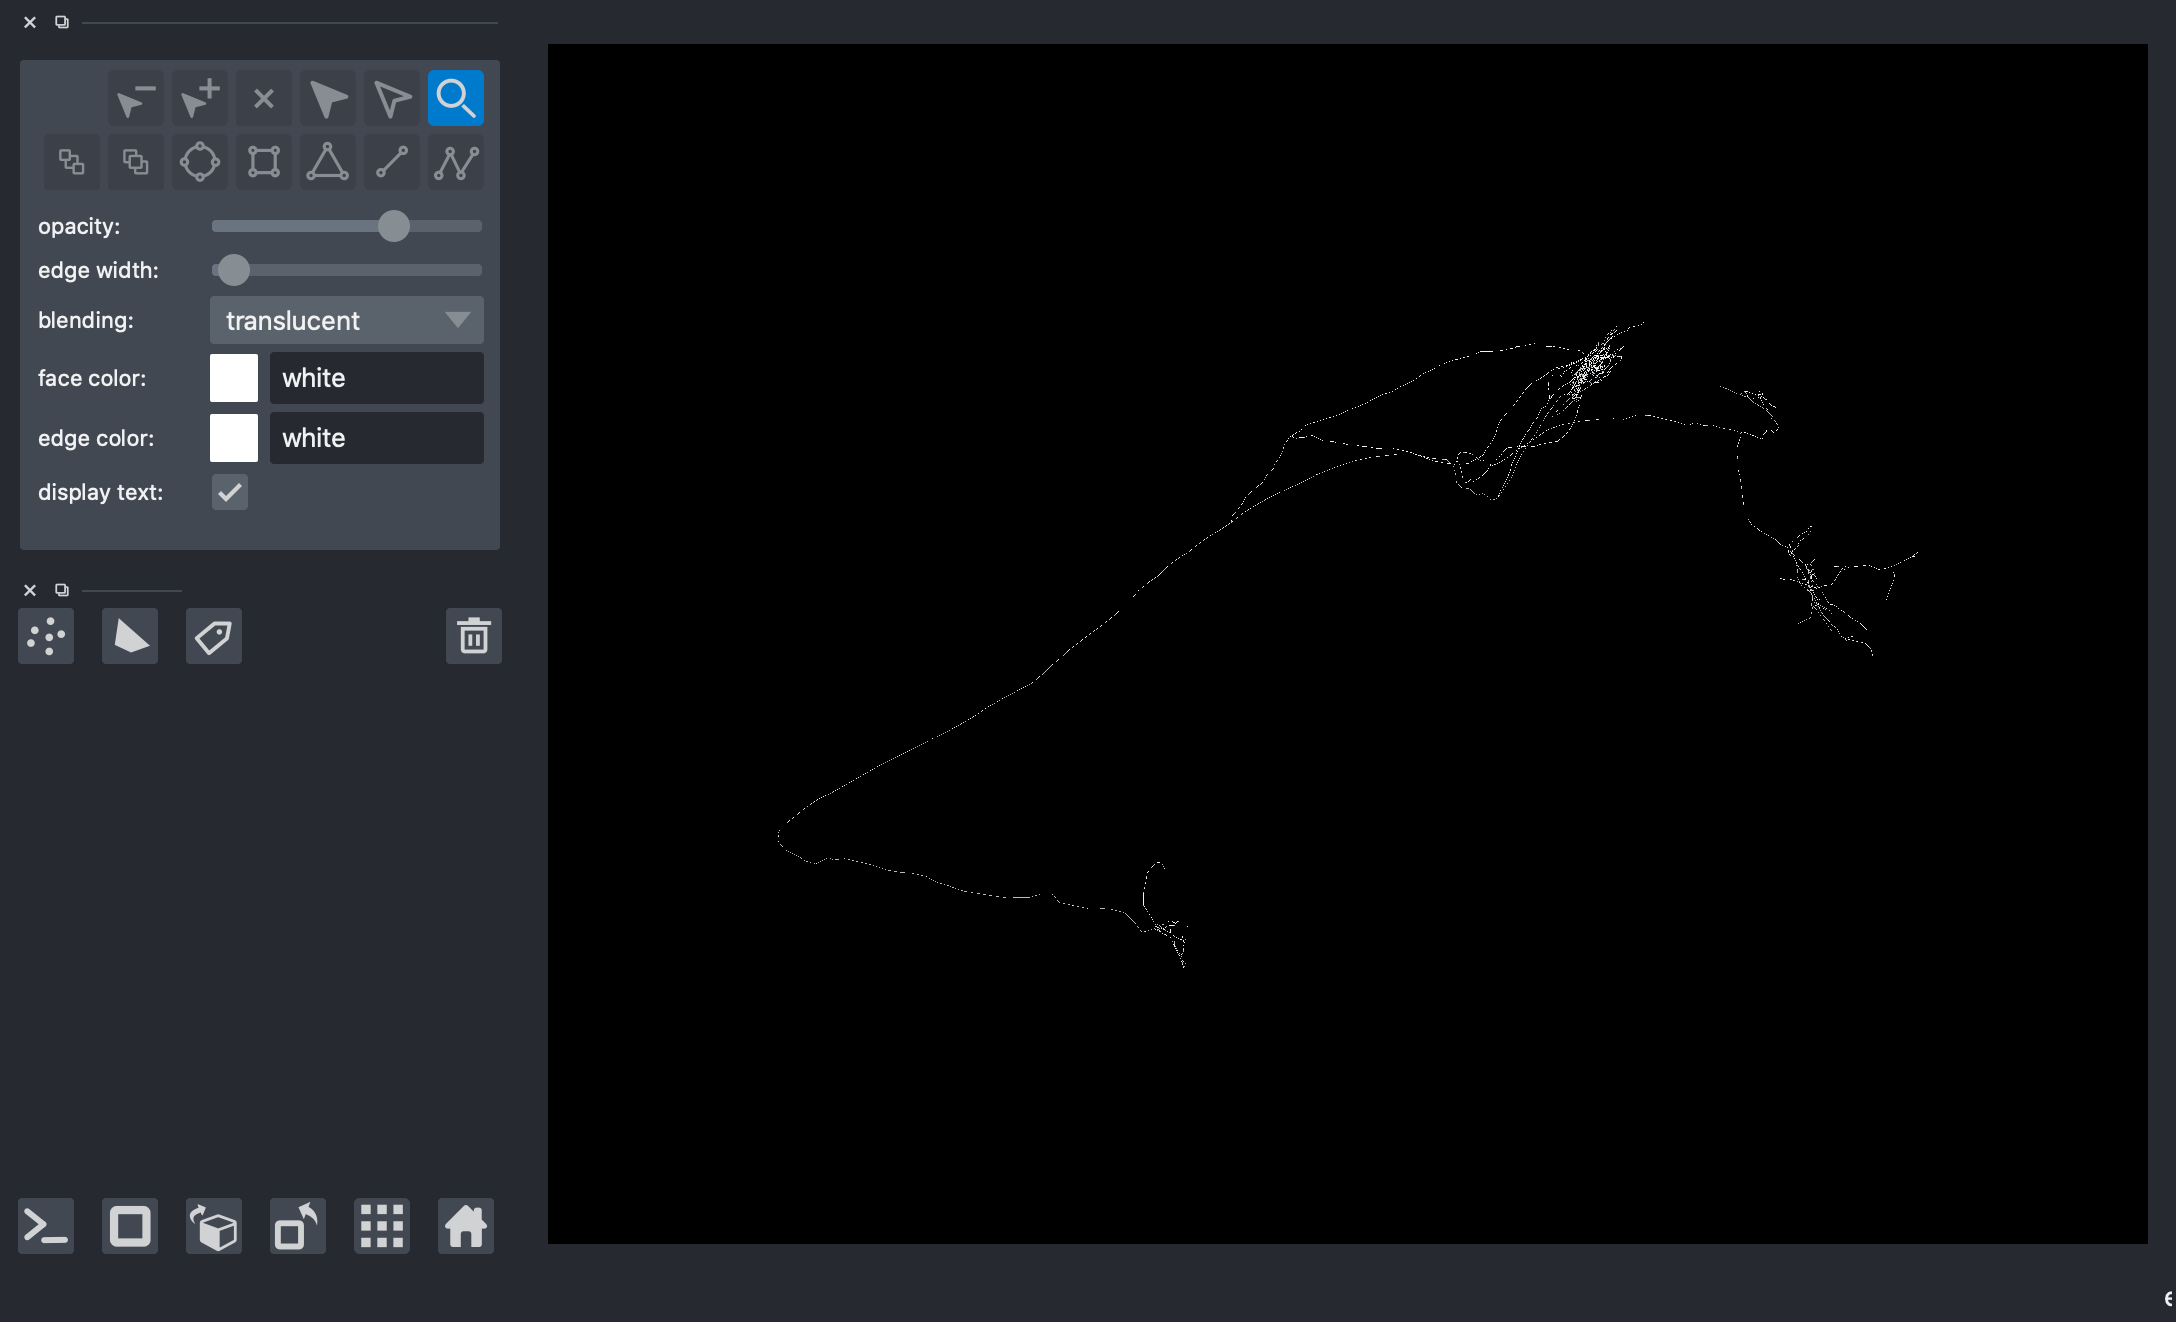

In [9]:
# viewer = napari.Viewer(ndisplay=3)
# viewer.add_shapes(data=paths, shape_type='path', edge_color='white', name='Skeleton 2')
# nbscreenshot(viewer)

## Loading sub-neuron

The image of the entire brain has dimensions of (33792, 25600, 13312) voxels. G-002 spans a sub-image of (7386, 9932, 5383) voxels. Both are too big to load in napari and overlay the neuron.
To circumvent this, we can crop out a smaller region of the neuron, load the sub-neuron, and load the corresponding sub-image.

In order to get a sub-neuron, we need to specify the `bounding_box` that will be used to crop the neuron. `bounding_box` is a length 2 tuple. The first element is one corner of the bounding box (inclusive) and the second element is the opposite corner of the bounding box (exclusive). Both corners are in voxel units.

`add_swc` can do all of this automatically when given `bounding_box` by following these steps:

1. `read_s3` to read the swc file into a pd.DataFrame
2. `swc_to_voxel` to convert the coordinates from spatial to voxel coordinates
3. `df_to_graph` to convert the DataFrame into a netwrokx.DiGraph
**3.1 `swc.get_sub_neuron` to crop the graph by `bounding_box`**
4. `graph_to_paths` to convert from a graph into a list of paths
5. `ViewerModel.add_shapes` to add the paths as a shape layer into the napari viewer

### 8. `swc_trace.get_sub_neuron(bounding_box)` 
### 9. `swc_trace.get_sub_neuron_paths(bounding_box)` 

This function crops a graph by removing edges. It removes edges that do not intersect the bounding box.

Edges that intersect the bounding box will have at least one of its vertices be contained by the bounding box. The algorithm follows this principle by checking the neighborhood of vertices.

For each vertex *v* in the graph:

1. Find vertices belonging to local neighborhood of *v*
2. If vertex *v* or any of its local neighborhood vertices are in the bounding box, do nothing. Otherwise, remove vertex *v* and its edges from the graph

We check the neighborhood of *v* along with *v* because we want the sub-neuron to show all edges that pass through the bounding box, including edges that are only partially contained.

`swc_trace.get_sub_neuron(bounding_box)` returns a sub neuron in graph format
`swc_trace.get_sub_neuron_paths(bounding_box)` returns a sub neuron in paths format

In [10]:
# # Create an NGL session to get the bounding box
# url = "s3://open-neurodata/brainlit/brain1"
# mip = 1
# ngl = NeuroglancerSession(url, mip=mip)

# img, bbbox, vox = ngl.pull_chunk(2, 300, 1)
# bbox = bbbox.to_list()
# box = (bbox[:3], bbox[3:])
# print(box)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]
Downloading: 52it [00:02, 19.61it/s]([7392, 2300, 3120], [7788, 2600, 3276])



459


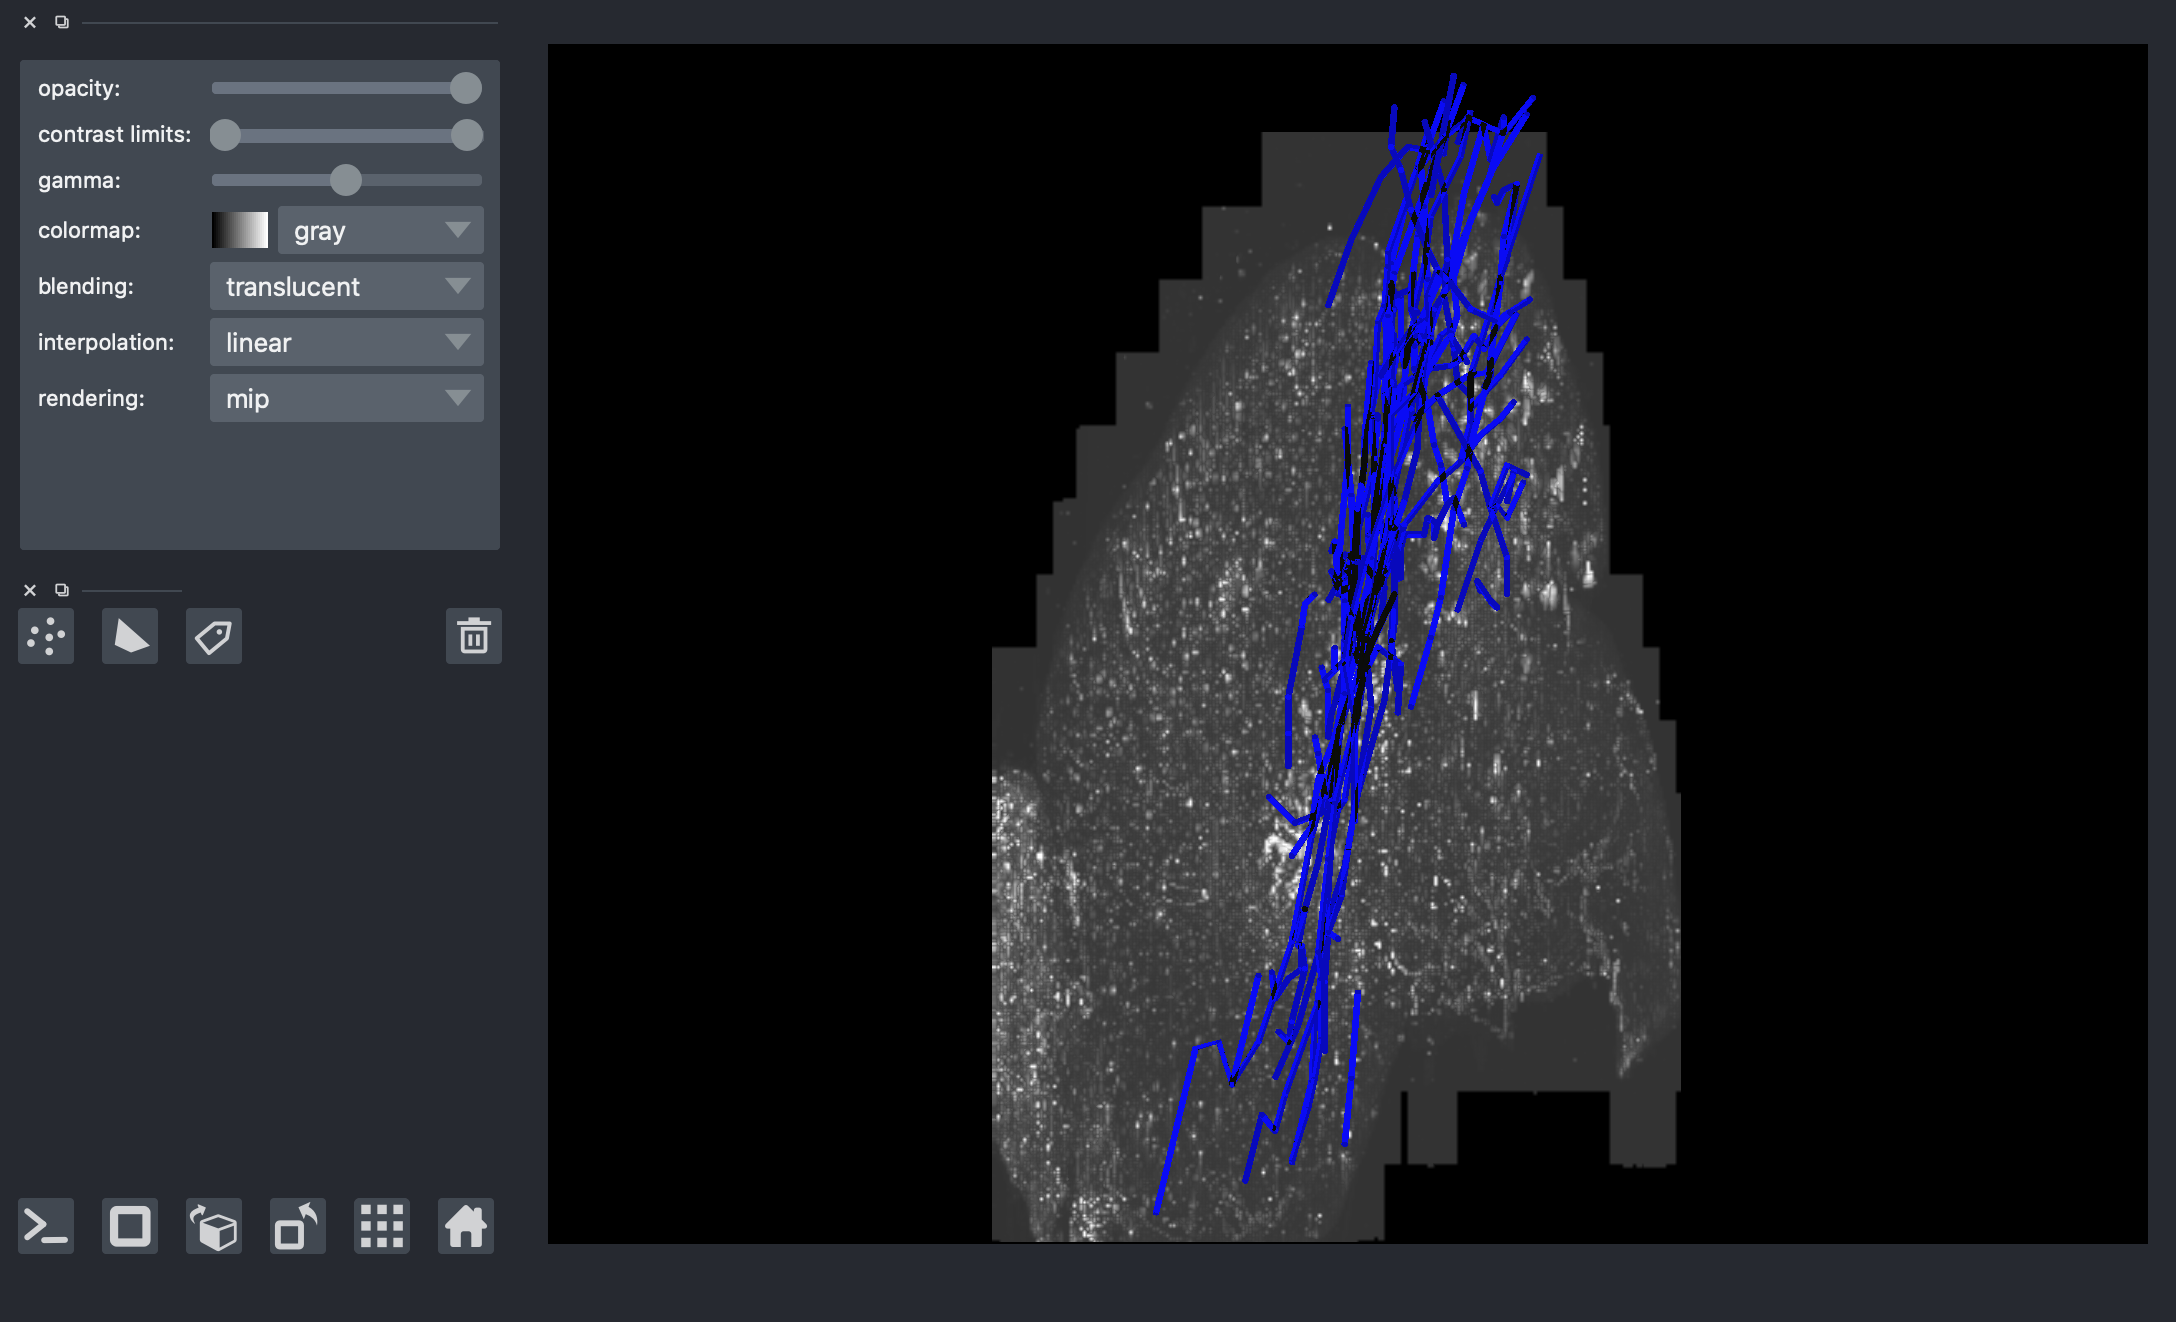

In [11]:
# G_sub = s3_trace.get_sub_neuron(box)
# paths_sub = s3_trace.get_sub_neuron_paths(box)
# print(len(G_sub))
# viewer = napari.Viewer(ndisplay=3)
# viewer.add_shapes(data=paths_sub, shape_type='path', edge_color='blue', name='sub-neuron')

# # overlay corresponding image (random image but correct should be G-002_15312-4400-6448_15840-4800-6656.tif' )
# image_path = str(Path().resolve().parents[2] / "data" / "data_octree" / 'default.0.tif') 
# img_comp = io.imread(image_path)
# img_comp = np.swapaxes(img_comp,0,2)

# viewer.add_image(img_comp)
# nbscreenshot(viewer)